In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight


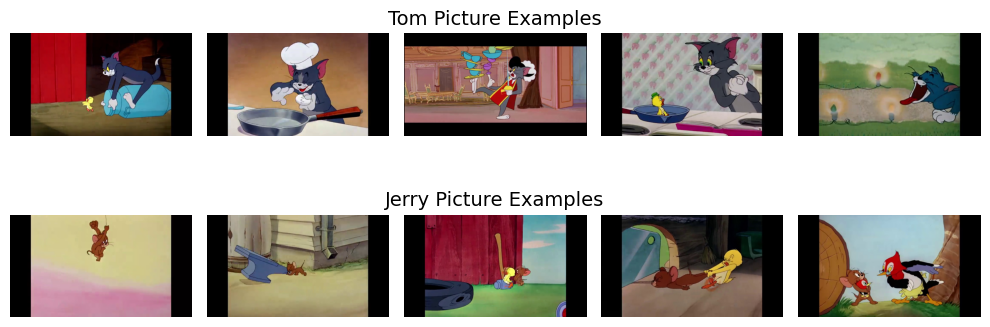

In [100]:
base_dir = "/Users/putrintun/Downloads/tom_and_jerry/train"
classes = ['Tom', 'Jerry']
samples_per_class = 5

fig, axes = plt.subplots(nrows=2, ncols=samples_per_class, figsize=(10, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.05)

for row_idx, class_name in enumerate(classes):
    class_dir = os.path.join(base_dir, class_name.lower())
    img_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'png', 'jpeg'))]
    selected_imgs = random.sample(img_files, min(samples_per_class, len(img_files)))

    for col_idx, img_path in enumerate(selected_imgs):
        ax = axes[row_idx][col_idx]
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')

        # Tambahkan judul di tengah kolom pertama
        if col_idx == samples_per_class // 2:
            ax.set_title(f"{class_name} Picture Examples", fontsize=14)

plt.tight_layout()
plt.show()

In [85]:
# --- PATH CONFIG ---
train_dir = "/Users/putrintun/Downloads/tom_and_jerry/train"
test_dir = "/Users/putrintun/Downloads/tom_and_jerry/test"

img_size = (224, 224)
batch_size = 32

# --- DATA GENERATOR ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# --- CLASS WEIGHT HANDLING ---
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))

# --- CNN MODEL ---
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- CALLBACKS ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)

# --- TRAINING ---
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict
)

Found 2045 images belonging to 2 classes.
Found 512 images belonging to 2 classes.
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 766ms/step - accuracy: 0.6181 - loss: 0.6586 - val_accuracy: 0.7656 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 922ms/step - accuracy: 0.7511 - loss: 0.5420 - val_accuracy: 0.7910 - val_loss: 0.4714 - learning_rate: 0.0010
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8523 - loss: 0.3582 - val_accuracy: 0.8633 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8993 - loss: 0.2598 - val_accuracy: 0.9121 - val_loss: 0.2270 - learning_rate: 0.0010
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9178 - loss: 0.2036 - val_accuracy: 0.9062 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9447 - loss: 0.1440 - val_accuracy: 0.8887 - val_loss: 0.2802 - learning_rate: 0.0010
Epoch 7/30


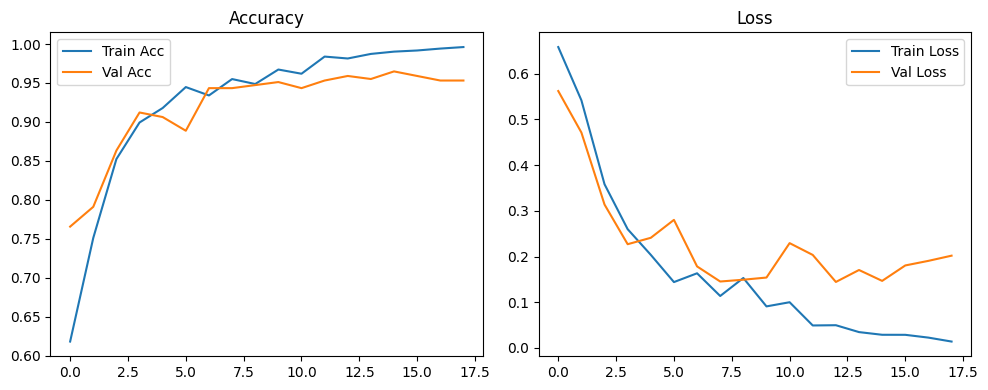

In [86]:
# --- PLOT TRAINING RESULT ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [87]:
# --- EVALUATION ---
def evaluate_model(model, val_generator):
    val_loss, val_acc = model.evaluate(val_generator)
    print(f'\nValidation Accuracy: {val_acc*100:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}')

    val_generator.reset()
    y_prob = model.predict(val_generator, steps=len(val_generator), verbose=0)
    y_pred = (y_prob > 0.5).astype(int).flatten()
    y_true = val_generator.classes

    return y_true, y_pred

y_true, y_pred = evaluate_model(model, test_gen)

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 537ms/step - accuracy: 0.9590 - loss: 0.1443

Validation Accuracy: 95.90%
Validation Loss: 0.1443



Classification Report:
              precision    recall  f1-score   support

       Jerry       0.95      0.95      0.95       204
         Tom       0.97      0.96      0.97       308

    accuracy                           0.96       512
   macro avg       0.96      0.96      0.96       512
weighted avg       0.96      0.96      0.96       512



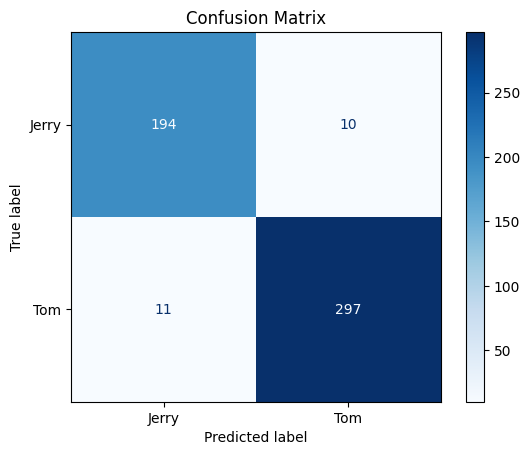

In [88]:
# --- CLASSIFICATION REPORT & CONFUSION MATRIX ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Jerry', 'Tom']))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Jerry', 'Tom'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

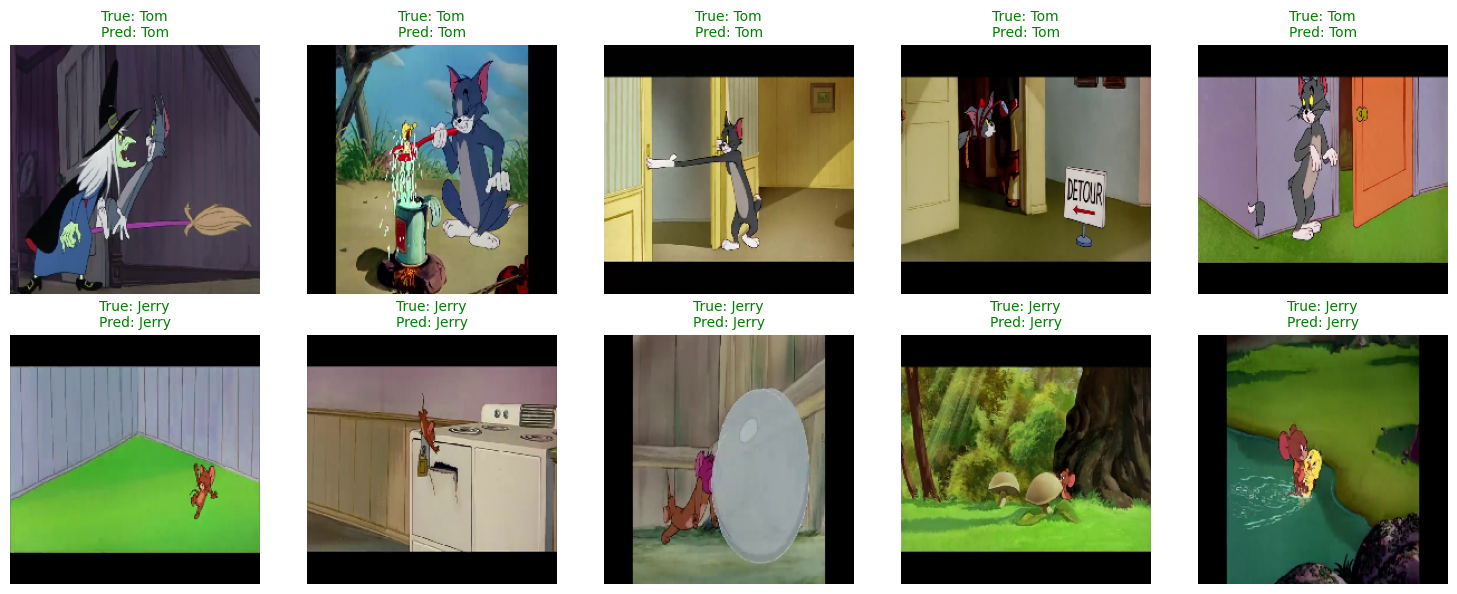

In [ ]:
# --- VISUALIZATION CLASSIFICATION ---
test_gen.reset()
all_images = []
all_labels = []

for _ in range(len(test_gen)):
    imgs, lbls = next(test_gen)
    all_images.extend(imgs)
    all_labels.extend(lbls)

tom_idx = [i for i, label in enumerate(all_labels) if label == 1]
jerry_idx = [i for i, label in enumerate(all_labels) if label == 0]

selected_tom = random.sample(tom_idx, 5)
selected_jerry = random.sample(jerry_idx, 5)

selected_indices = selected_tom + selected_jerry
selected_images = [all_images[i] for i in selected_indices]
selected_labels = [all_labels[i] for i in selected_indices]

selected_images_array = np.array(selected_images)
pred_probs = model.predict(selected_images_array, verbose=0)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

class_indices = test_gen.class_indices
idx_to_class = {v: k.capitalize() for k, v in class_indices.items()}

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(selected_images[i])
    true_label = idx_to_class[int(selected_labels[i])]
    pred_label = idx_to_class[int(pred_labels[i])]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
